In [ ]:
#@title Mount google drive

from google.colab import drive
drive.mount('/content/drive')

%cd './drive/MyDrive/gaze_estimation'


Mounted at /content/drive
/content/drive/MyDrive/gaze_estimation


In [ ]:
import os
import time
import copy
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression


from loss.likelihood_hetero import multivariate_nll_hetero_i, multivariate_njll_hetero_i
from hglm.precision_module import precision_module
from loss.h_likelihood_precision import nhll_hetero_precision
from util import make_reproducibility, TensorDataset, convert_to_xyz, mae, make_arbitrary_masking, k_fold_index
from networks import *
from hglm.hglm_hetero_precision import hetero_precision_without_val

In [ ]:
#@title Load preprocessed & subsampled data (LOOCV)

ids =                    np.load('../mpii_dataset/loocv_ids.npy')
images = torch.as_tensor(np.load('../mpii_dataset/loocv_images.npy'), dtype=torch.float)
hps =    torch.as_tensor(np.load('../mpii_dataset/loocv_2d_hps.npy'), dtype=torch.float)
gazes =  torch.as_tensor(np.load('../mpii_dataset/loocv_2d_gazes.npy'), dtype=torch.float)

# Data Load

In [ ]:
# #@title test : check reproducibility

# from loss.likelihood_hetero import multivariate_nll_hetero_i, multivariate_njll_hetero_i
# from hglm.covariance_module import covariance_module
# from loss.h_likelihood_covariance import nhll_hetero_arbitrary
# from hglm.hglm_hetero_arbitrary import hetero_covariance_without_val

# for fold in [0] :

#     train_ids = np.concatenate([ids[:fold], ids[(fold+1):]]).reshape(-1)
#     train_images = torch.cat([images[:fold], images[(fold+1):]]).reshape(-1,36,60)
#     train_hps = torch.cat([hps[:fold], hps[(fold+1):]]).reshape(-1,2)
#     train_gazes = torch.cat([gazes[:fold], gazes[(fold+1):]]).reshape(-1,2)

#     test_ids = ids[fold]
#     test_images = images[fold]
#     test_hps = hps[fold]
#     test_gazes = gazes[fold]

#     hetero_covariance_without_val(
#         train_ids, train_images, train_hps, train_gazes,
#         test_ids, test_images, test_hps, test_gazes,
#         ResNet_batchnorm.ResNet_batchnorm, hidden_features=500, K=2,
#         mean_lr=5e-3, variance_lr=1e-3, weight_decay=0, batch_size=1000,
#         pretrain_iter=1, m_pretrain_epoch=50, v_pretrain_epoch=1, max_iter=1, mean_epoch=1, v_step_iter=1, patience=10,
#         device=torch.device('cuda:0'), experiment_name='test', SEED=10,
#         normalize=True, deg=True, test_unseen=False, weighted=True, variance_check=True, verbose=False, bins=50, reset_opt=False)


In [ ]:
device = torch.device('cuda:0')
seed = 10

experiment_name = 'loocv'
batch_size = 1000
pretrain_iter = 1
m_pretrain_epoch = 50
v_pretrain_epoch = 20
max_iter = 150
mean_epoch = 10
v_step_iter = 100
patience = 10
mean_lr = 5e-3
variance_lr = 1e-3
weight_decay = 0
hidden_features = 500
reset_opt=False
initialize_Sigma=True

In [ ]:
res_list = []

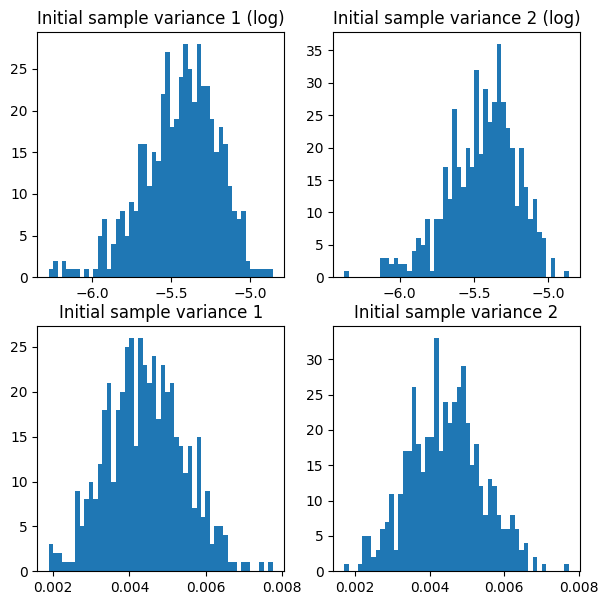

Mean Pretrain starts


  0%|          | 0/1 [00:00<?, ?it/s]

0-th epoch last batch Pretrain h-lik loss (m-step) : 28.31328582763672
1-th epoch last batch Pretrain h-lik loss (m-step) : 23.044126510620117
2-th epoch last batch Pretrain h-lik loss (m-step) : 19.466617584228516
3-th epoch last batch Pretrain h-lik loss (m-step) : 17.17896270751953
4-th epoch last batch Pretrain h-lik loss (m-step) : 14.122069358825684
5-th epoch last batch Pretrain h-lik loss (m-step) : 12.860252380371094
6-th epoch last batch Pretrain h-lik loss (m-step) : 12.345837593078613
7-th epoch last batch Pretrain h-lik loss (m-step) : 11.217686653137207
8-th epoch last batch Pretrain h-lik loss (m-step) : 10.105929374694824
9-th epoch last batch Pretrain h-lik loss (m-step) : 8.681018829345703
10-th epoch last batch Pretrain h-lik loss (m-step) : 8.109246253967285
11-th epoch last batch Pretrain h-lik loss (m-step) : 6.952049255371094
12-th epoch last batch Pretrain h-lik loss (m-step) : 7.106178283691406
13-th epoch last batch Pretrain h-lik loss (m-step) : 5.89362621307

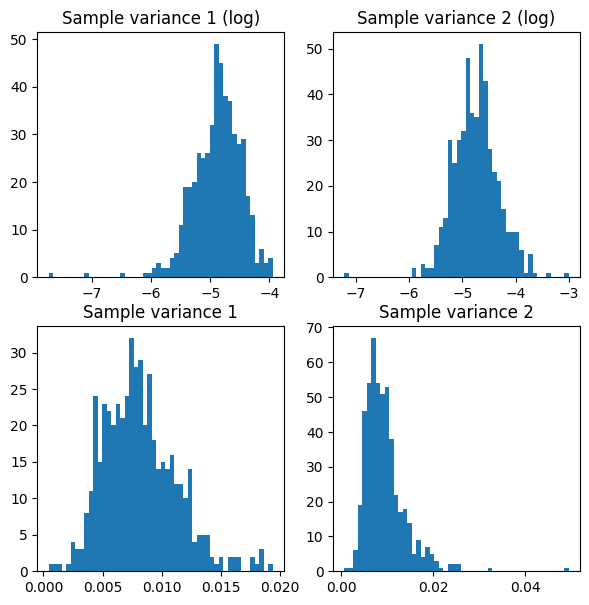

Mean Pretrain spends 235.6867 sec
Variance Pretrain starts


  0%|          | 0/20 [00:00<?, ?it/s]

0-th epoch last batch Pretrain h-lik loss (v-step) : 4.1785197257995605
1-th epoch last batch Pretrain h-lik loss (v-step) : 3.881817579269409
2-th epoch last batch Pretrain h-lik loss (v-step) : 4.651553153991699
3-th epoch last batch Pretrain h-lik loss (v-step) : 4.738988399505615
4-th epoch last batch Pretrain h-lik loss (v-step) : 4.123592376708984
5-th epoch last batch Pretrain h-lik loss (v-step) : 4.443446159362793
6-th epoch last batch Pretrain h-lik loss (v-step) : 4.996423244476318
7-th epoch last batch Pretrain h-lik loss (v-step) : 4.237616062164307
8-th epoch last batch Pretrain h-lik loss (v-step) : 4.358898162841797
9-th epoch last batch Pretrain h-lik loss (v-step) : 3.9849133491516113
10-th epoch last batch Pretrain h-lik loss (v-step) : 3.6600821018218994
11-th epoch last batch Pretrain h-lik loss (v-step) : 4.096007823944092
12-th epoch last batch Pretrain h-lik loss (v-step) : 4.3547868728637695
13-th epoch last batch Pretrain h-lik loss (v-step) : 4.34757757186889

  0%|          | 0/150 [00:00<?, ?it/s]

0-th epoch full h-lik loss (M-step) : 55.02776336669922
1-th epoch full h-lik loss (M-step) : 24.617752075195312
2-th epoch full h-lik loss (M-step) : 18.28665542602539
3-th epoch full h-lik loss (M-step) : 20.17276382446289
4-th epoch full h-lik loss (M-step) : 13.114843368530273
5-th epoch full h-lik loss (M-step) : 15.055109024047852
6-th epoch full h-lik loss (M-step) : 11.707965850830078
7-th epoch full h-lik loss (M-step) : 32.55427932739258
8-th epoch full h-lik loss (M-step) : 20.249465942382812
9-th epoch full h-lik loss (M-step) : 14.89603042602539
9-th V-step train loss : 11.150314331054688
19-th V-step train loss : 10.785133361816406
29-th V-step train loss : 10.718161582946777
39-th V-step train loss : 10.62973690032959
49-th V-step train loss : 10.56656551361084
59-th V-step train loss : 10.546880722045898
69-th V-step train loss : 10.531057357788086
79-th V-step train loss : 10.51736831665039
89-th V-step train loss : 10.507594108581543
99-th V-step train loss : 10.49896

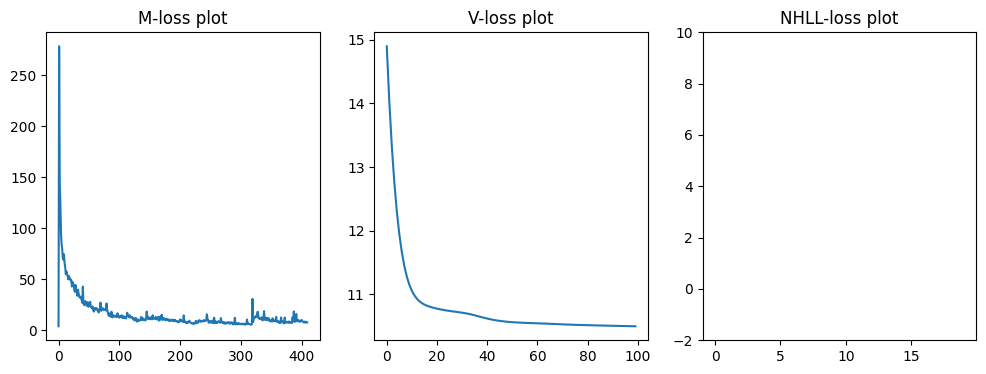

0-th main train train MAE, MSE, NHLL : 1.4830 deg, 1.5206, 10.4990
0-th main train test MAE, MSE, NHLL : 2.6535 deg, 6.5056, 49.8244
0-th main train test MAE, MSE: 3.7434 deg, 10.6461


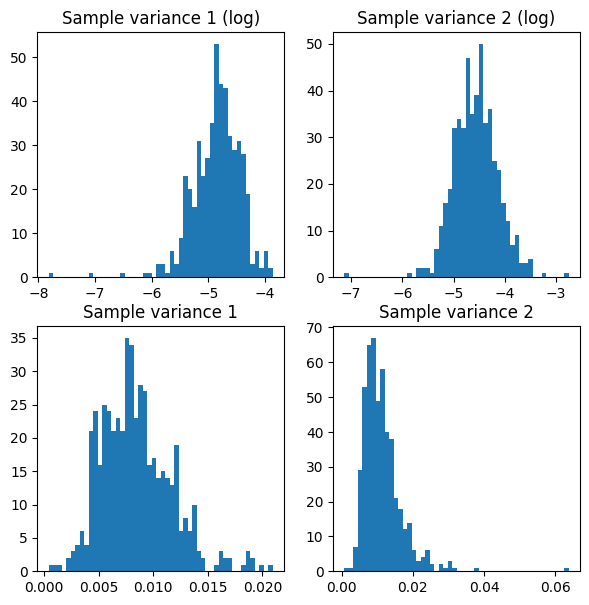

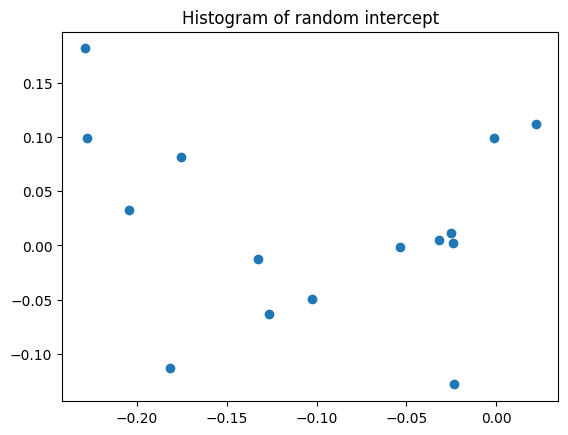

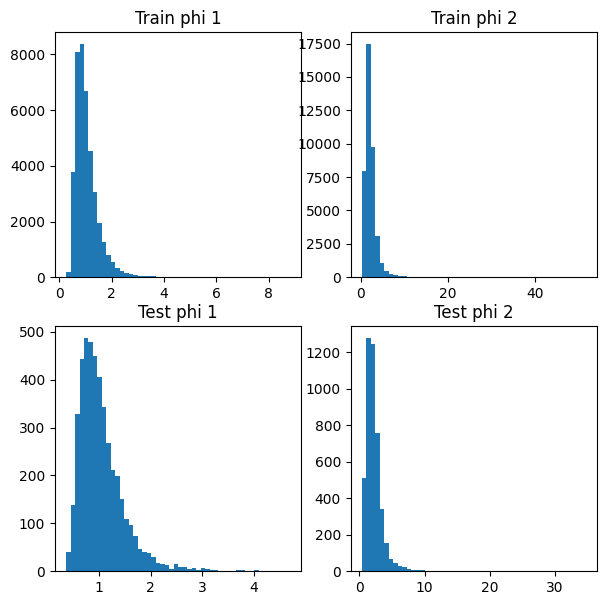

0-th epoch full h-lik loss (M-step) : 6.712556838989258
1-th epoch full h-lik loss (M-step) : 5.77872371673584
2-th epoch full h-lik loss (M-step) : 5.561457633972168
3-th epoch full h-lik loss (M-step) : 5.530579566955566
4-th epoch full h-lik loss (M-step) : 5.539751052856445
5-th epoch full h-lik loss (M-step) : 5.587140083312988
6-th epoch full h-lik loss (M-step) : 5.392640113830566
7-th epoch full h-lik loss (M-step) : 5.524778842926025
8-th epoch full h-lik loss (M-step) : 5.435310363769531
9-th epoch full h-lik loss (M-step) : 5.447277069091797
9-th V-step train loss : 4.391554832458496
19-th V-step train loss : 3.7398934364318848
29-th V-step train loss : 3.5424816608428955
39-th V-step train loss : 3.420869827270508
49-th V-step train loss : 3.3782172203063965
59-th V-step train loss : 3.3549556732177734
69-th V-step train loss : 3.343050718307495
79-th V-step train loss : 3.3328704833984375
89-th V-step train loss : 3.324986457824707
99-th V-step train loss : 3.3186645507812

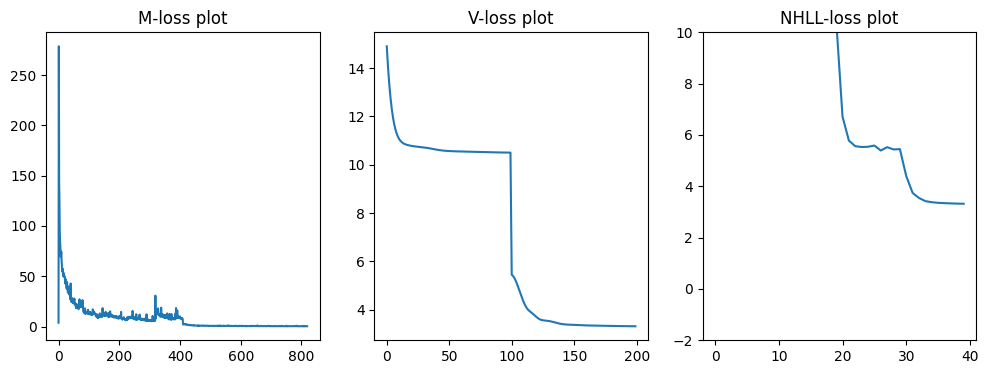

1-th main train train MAE, MSE, NHLL : 0.5809 deg, 0.2359, 3.3187
1-th main train test MAE, MSE, NHLL : 2.3438 deg, 5.6611, 60.8043
1-th main train test MAE, MSE: 3.5234 deg, 9.6291


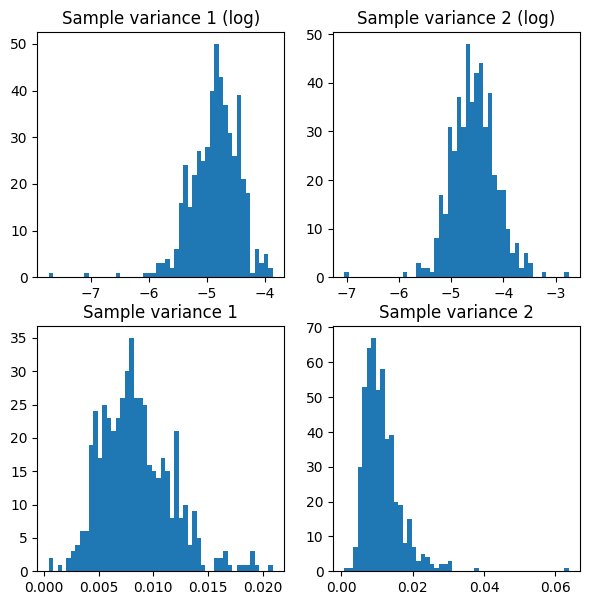

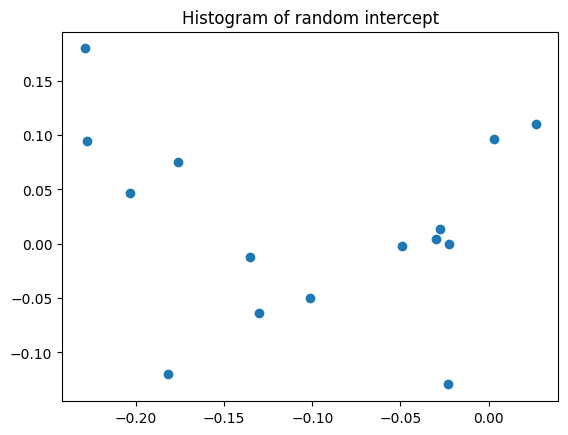

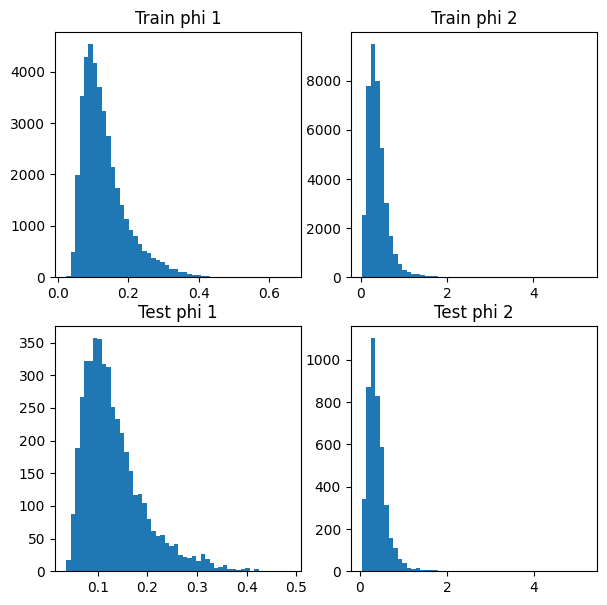

0-th epoch full h-lik loss (M-step) : 73.31199645996094
1-th epoch full h-lik loss (M-step) : 51.85655975341797
2-th epoch full h-lik loss (M-step) : 31.962461471557617
3-th epoch full h-lik loss (M-step) : 20.11993408203125
4-th epoch full h-lik loss (M-step) : 16.05502700805664
5-th epoch full h-lik loss (M-step) : 12.6214599609375
6-th epoch full h-lik loss (M-step) : 9.022674560546875
7-th epoch full h-lik loss (M-step) : 9.49344253540039
8-th epoch full h-lik loss (M-step) : 8.02366828918457
9-th epoch full h-lik loss (M-step) : 9.434372901916504
9-th V-step train loss : 7.57489013671875
19-th V-step train loss : 7.64125919342041
29-th V-step train loss : 7.502411842346191
39-th V-step train loss : 7.434136390686035
49-th V-step train loss : 7.412771224975586
59-th V-step train loss : 7.399952411651611
69-th V-step train loss : 7.390054225921631
79-th V-step train loss : 7.384342670440674
89-th V-step train loss : 7.37907600402832
99-th V-step train loss : 7.374847412109375


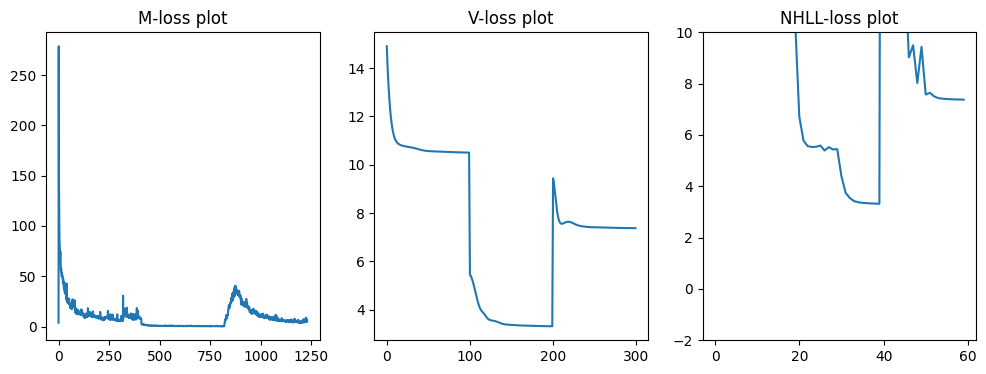

2-th main train train MAE, MSE, NHLL : 1.0684 deg, 0.7644, 7.3749
2-th main train test MAE, MSE, NHLL : 2.4909 deg, 5.9934, 40.4958
2-th main train test MAE, MSE: 3.5749 deg, 9.8603


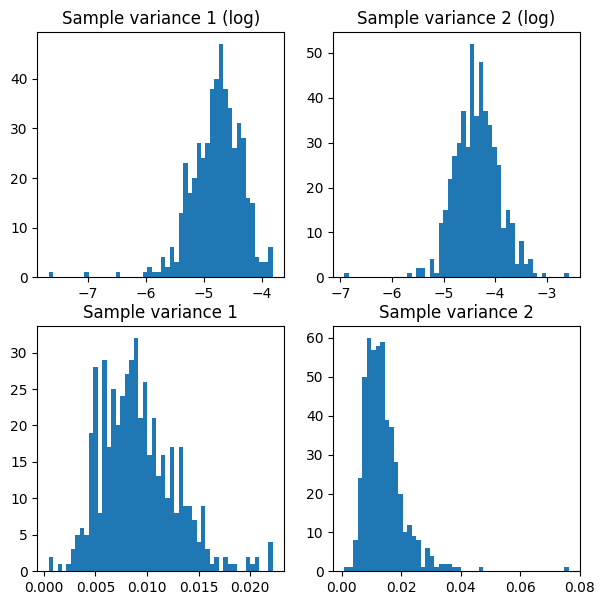

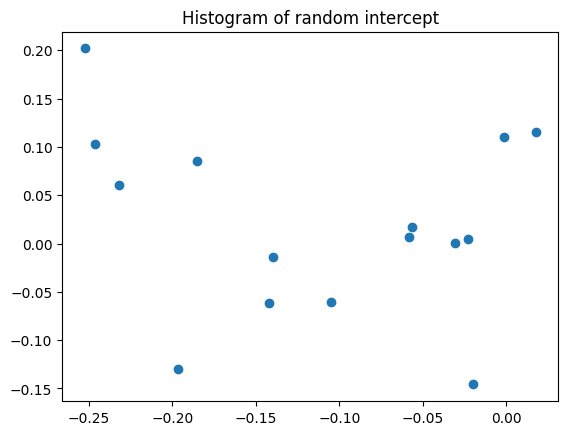

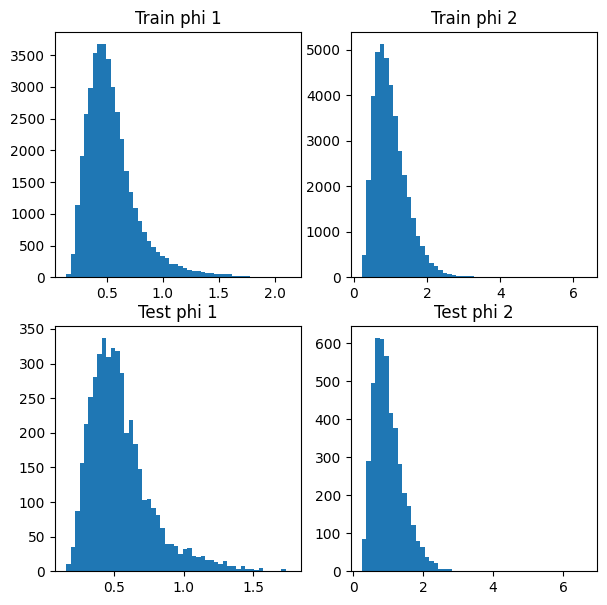

0-th epoch full h-lik loss (M-step) : 4.85548210144043
1-th epoch full h-lik loss (M-step) : 4.307567119598389
2-th epoch full h-lik loss (M-step) : 4.3671979904174805
3-th epoch full h-lik loss (M-step) : 4.412801742553711
4-th epoch full h-lik loss (M-step) : 4.213560104370117
5-th epoch full h-lik loss (M-step) : 4.513938903808594
6-th epoch full h-lik loss (M-step) : 4.1981306076049805
7-th epoch full h-lik loss (M-step) : 4.271398067474365
8-th epoch full h-lik loss (M-step) : 4.113758087158203
9-th epoch full h-lik loss (M-step) : 4.109130382537842
9-th V-step train loss : 3.0605850219726562
19-th V-step train loss : 2.2698283195495605
29-th V-step train loss : 2.057894229888916
39-th V-step train loss : 1.946007251739502
49-th V-step train loss : 1.8797892332077026
59-th V-step train loss : 1.8483515977859497
69-th V-step train loss : 1.8267637491226196
79-th V-step train loss : 1.8135733604431152
89-th V-step train loss : 1.8037561178207397
99-th V-step train loss : 1.796326279

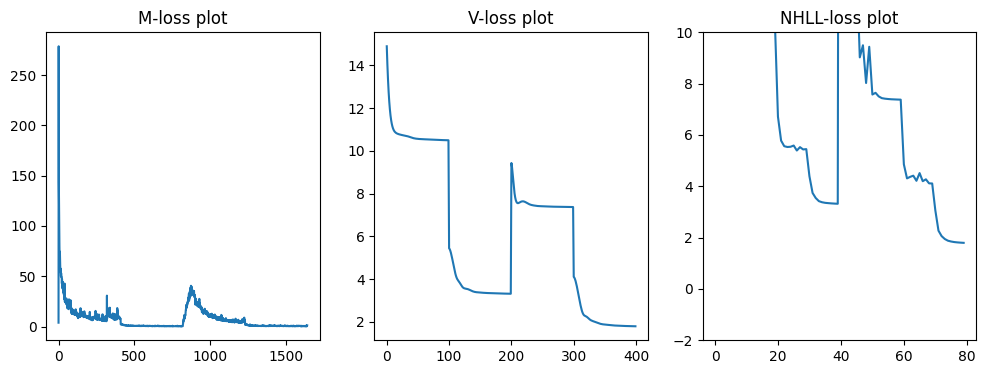

3-th main train train MAE, MSE, NHLL : 0.3869 deg, 0.1009, 1.7963
3-th main train test MAE, MSE, NHLL : 2.3137 deg, 5.4737, 119.5004
3-th main train test MAE, MSE: 3.4666 deg, 9.3966


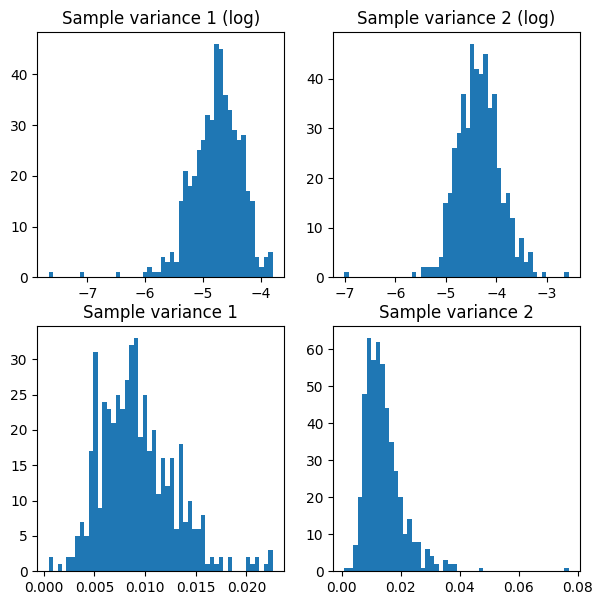

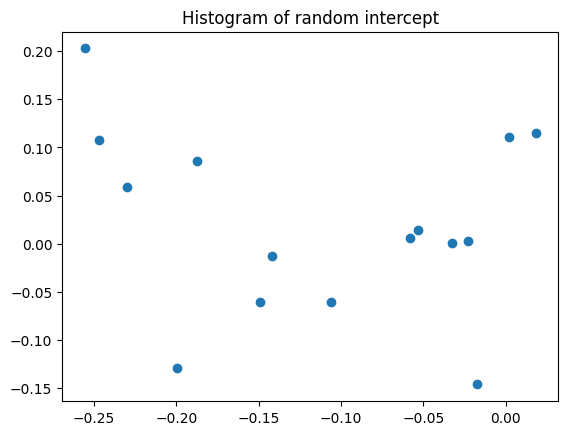

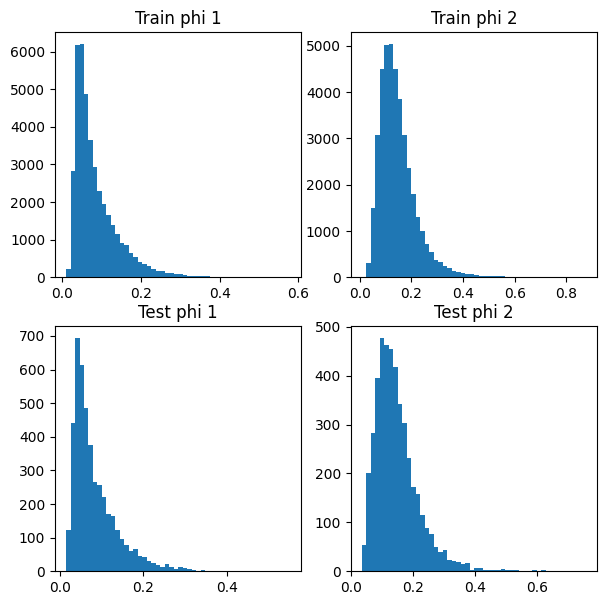

0-th epoch full h-lik loss (M-step) : 187.7313995361328
1-th epoch full h-lik loss (M-step) : 123.47346496582031
2-th epoch full h-lik loss (M-step) : 59.10223388671875
3-th epoch full h-lik loss (M-step) : 31.394332885742188
4-th epoch full h-lik loss (M-step) : 22.707332611083984
5-th epoch full h-lik loss (M-step) : 17.2696533203125
6-th epoch full h-lik loss (M-step) : 18.697669982910156
7-th epoch full h-lik loss (M-step) : 17.3701171875
8-th epoch full h-lik loss (M-step) : 14.89161205291748
9-th epoch full h-lik loss (M-step) : 18.321491241455078
9-th V-step train loss : 12.754355430603027
19-th V-step train loss : 12.779367446899414
29-th V-step train loss : 12.634600639343262
39-th V-step train loss : 12.39093017578125
49-th V-step train loss : 12.34459114074707
59-th V-step train loss : 12.316454887390137
69-th V-step train loss : 12.295890808105469
79-th V-step train loss : 12.285726547241211
89-th V-step train loss : 12.277318954467773
99-th V-step train loss : 12.270755767

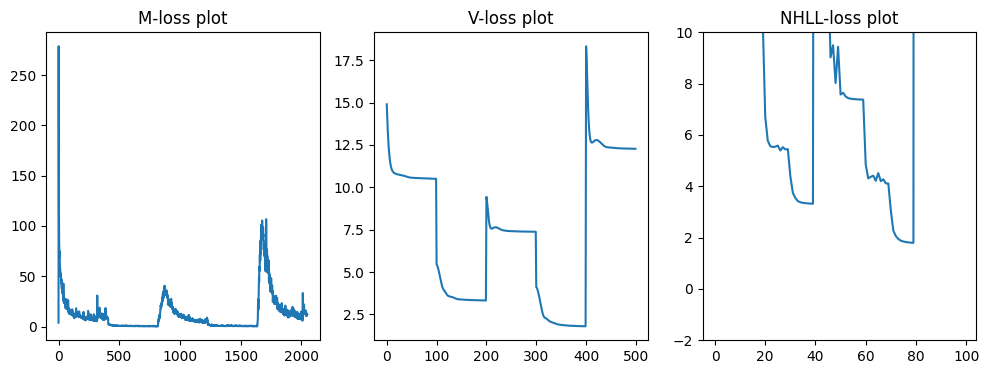

4-th main train train MAE, MSE, NHLL : 1.0650 deg, 0.7964, 12.2708
4-th main train test MAE, MSE, NHLL : 2.4451 deg, 5.8319, 81.7536
4-th main train test MAE, MSE: 3.5550 deg, 9.7778


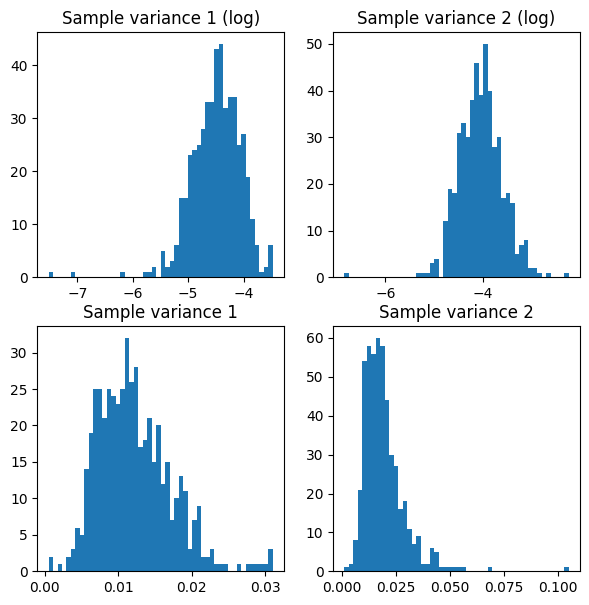

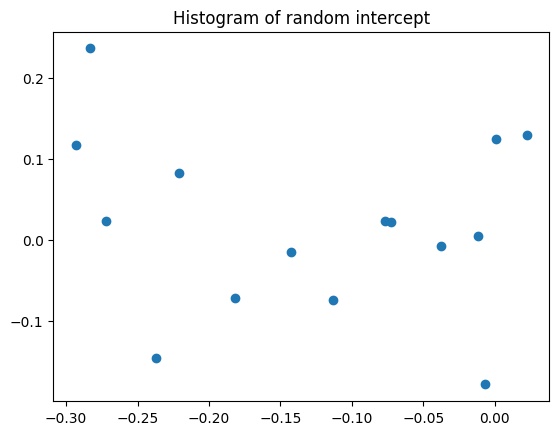

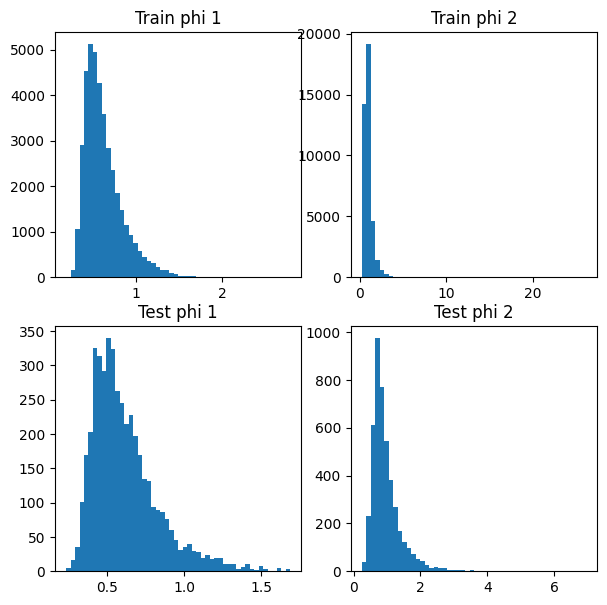

0-th epoch full h-lik loss (M-step) : 6.658544540405273
1-th epoch full h-lik loss (M-step) : 4.783933639526367
2-th epoch full h-lik loss (M-step) : 4.6778244972229
3-th epoch full h-lik loss (M-step) : 4.719331741333008
4-th epoch full h-lik loss (M-step) : 4.386385917663574
5-th epoch full h-lik loss (M-step) : 4.301262378692627
6-th epoch full h-lik loss (M-step) : 4.346136093139648
7-th epoch full h-lik loss (M-step) : 4.300440788269043
8-th epoch full h-lik loss (M-step) : 4.232822418212891
9-th epoch full h-lik loss (M-step) : 4.319969654083252
9-th V-step train loss : 3.693370819091797
19-th V-step train loss : 2.9156808853149414
29-th V-step train loss : 2.7736976146698
39-th V-step train loss : 2.669771432876587
49-th V-step train loss : 2.604187488555908
59-th V-step train loss : 2.5714287757873535
69-th V-step train loss : 2.5486233234405518
79-th V-step train loss : 2.5327768325805664
89-th V-step train loss : 2.5208802223205566
99-th V-step train loss : 2.5113847255706787

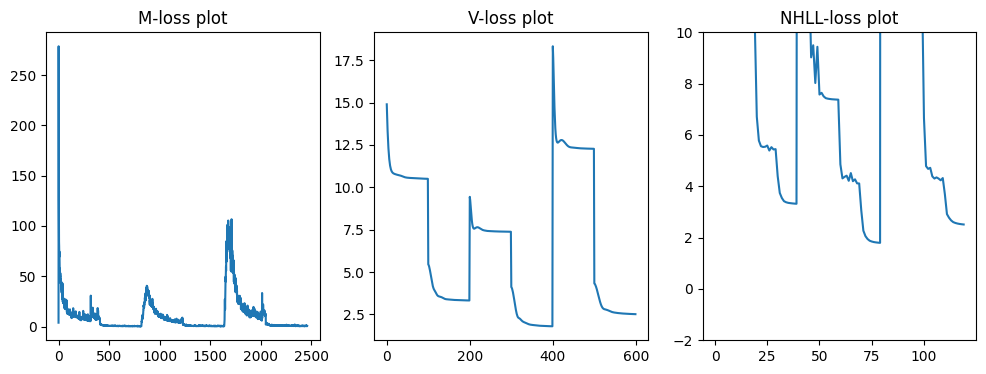

5-th main train train MAE, MSE, NHLL : 0.4454 deg, 0.1530, 2.5114
5-th main train test MAE, MSE, NHLL : 2.2953 deg, 5.4359, 86.1546
5-th main train test MAE, MSE: 3.4779 deg, 9.4528


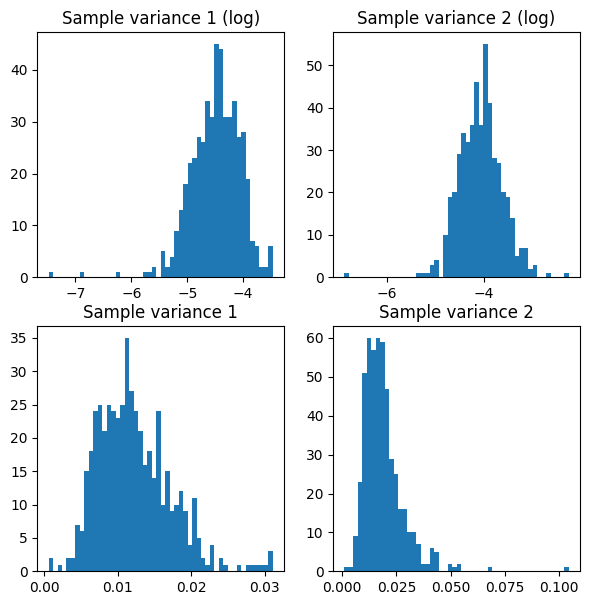

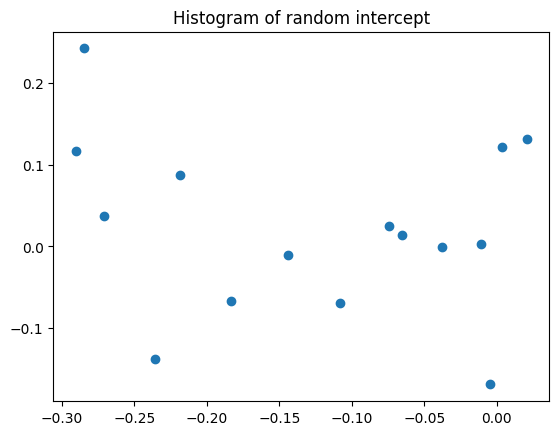

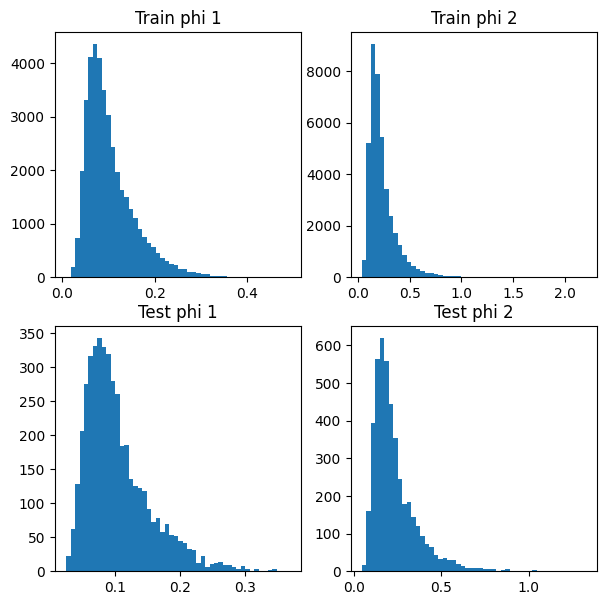

0-th epoch full h-lik loss (M-step) : 16.260295867919922
1-th epoch full h-lik loss (M-step) : 14.157903671264648
2-th epoch full h-lik loss (M-step) : 16.51446533203125
3-th epoch full h-lik loss (M-step) : 12.427763938903809
4-th epoch full h-lik loss (M-step) : 9.180795669555664
5-th epoch full h-lik loss (M-step) : 17.532936096191406
6-th epoch full h-lik loss (M-step) : 8.019046783447266
7-th epoch full h-lik loss (M-step) : 7.610411167144775
8-th epoch full h-lik loss (M-step) : 7.003146171569824
9-th epoch full h-lik loss (M-step) : 6.76701545715332
9-th V-step train loss : 5.819002151489258
19-th V-step train loss : 5.702801704406738
29-th V-step train loss : 5.650915145874023
39-th V-step train loss : 5.596175193786621
49-th V-step train loss : 5.583907127380371
59-th V-step train loss : 5.572218894958496
69-th V-step train loss : 5.564943790435791
79-th V-step train loss : 5.559409141540527
89-th V-step train loss : 5.5547332763671875
99-th V-step train loss : 5.5508785247802

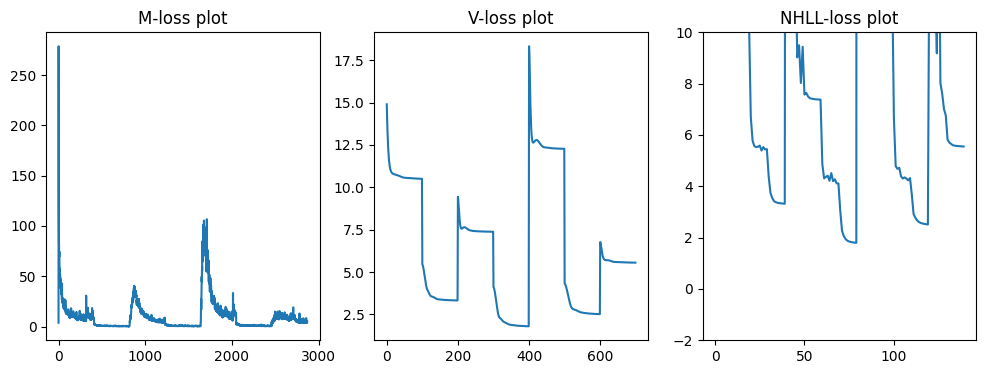

6-th main train train MAE, MSE, NHLL : 0.7411 deg, 0.3810, 5.5509
6-th main train test MAE, MSE, NHLL : 2.3765 deg, 5.5866, 55.1835
6-th main train test MAE, MSE: 3.4676 deg, 9.3455


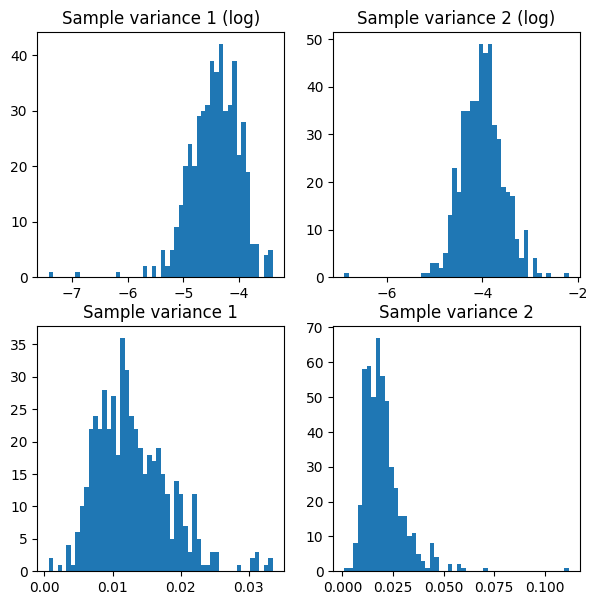

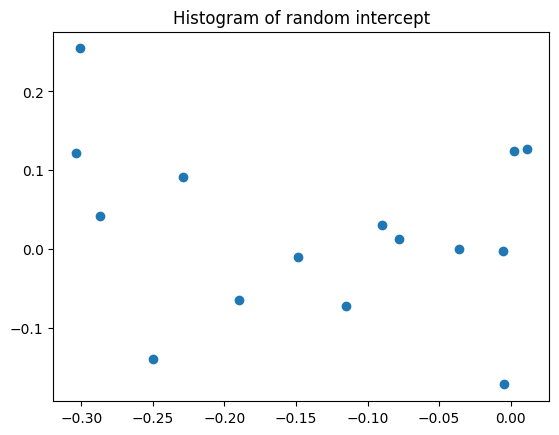

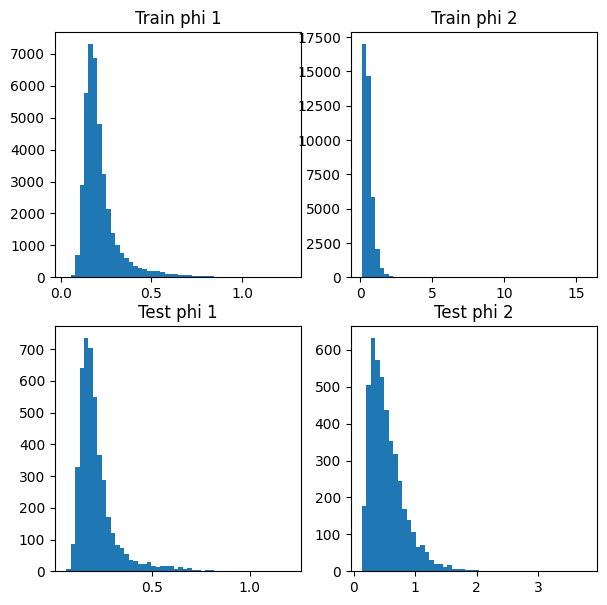

0-th epoch full h-lik loss (M-step) : 4.23312520980835
1-th epoch full h-lik loss (M-step) : 3.6672701835632324
2-th epoch full h-lik loss (M-step) : 3.773958206176758
3-th epoch full h-lik loss (M-step) : 2.9700469970703125
4-th epoch full h-lik loss (M-step) : 3.4262285232543945
5-th epoch full h-lik loss (M-step) : 4.088915824890137
6-th epoch full h-lik loss (M-step) : 4.408947467803955
7-th epoch full h-lik loss (M-step) : 3.0320920944213867
8-th epoch full h-lik loss (M-step) : 2.9091060161590576
9-th epoch full h-lik loss (M-step) : 3.342578887939453
9-th V-step train loss : 3.0831103324890137
19-th V-step train loss : 2.8505730628967285
29-th V-step train loss : 2.7520594596862793
39-th V-step train loss : 2.6801676750183105
49-th V-step train loss : 2.644606113433838
59-th V-step train loss : 2.61985445022583
69-th V-step train loss : 2.600980043411255
79-th V-step train loss : 2.5858960151672363
89-th V-step train loss : 2.5734305381774902
99-th V-step train loss : 2.56297492

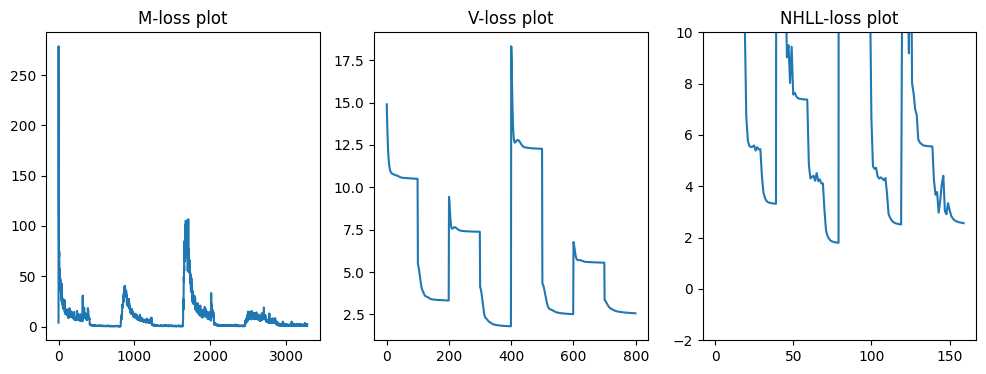

7-th main train train MAE, MSE, NHLL : 0.4535 deg, 0.1436, 2.5630
7-th main train test MAE, MSE, NHLL : 2.3160 deg, 5.4412, 91.8588
7-th main train test MAE, MSE: 3.4155 deg, 9.1274


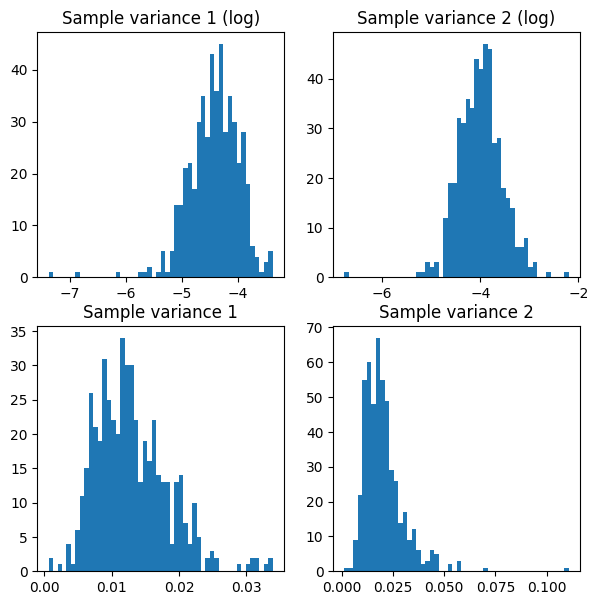

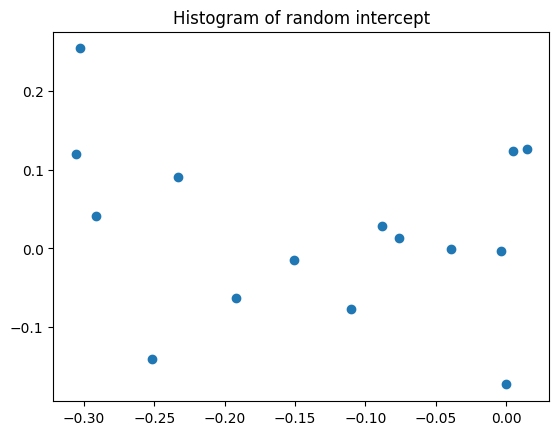

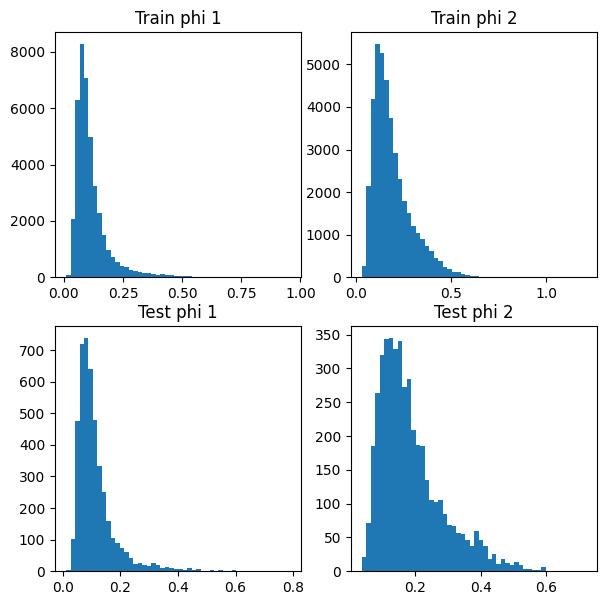

0-th epoch full h-lik loss (M-step) : 9.950104713439941
1-th epoch full h-lik loss (M-step) : 16.37087631225586
2-th epoch full h-lik loss (M-step) : 21.84063148498535
3-th epoch full h-lik loss (M-step) : 11.462432861328125
4-th epoch full h-lik loss (M-step) : 10.932035446166992
5-th epoch full h-lik loss (M-step) : 14.33565902709961
6-th epoch full h-lik loss (M-step) : 12.804149627685547
7-th epoch full h-lik loss (M-step) : 13.469820022583008
8-th epoch full h-lik loss (M-step) : 6.498422145843506
9-th epoch full h-lik loss (M-step) : 7.823220252990723
9-th V-step train loss : 6.253196716308594
19-th V-step train loss : 6.221515655517578
29-th V-step train loss : 6.150019645690918
39-th V-step train loss : 6.069075584411621
49-th V-step train loss : 6.056005477905273
59-th V-step train loss : 6.040096282958984
69-th V-step train loss : 6.029984474182129
79-th V-step train loss : 6.02287483215332
89-th V-step train loss : 6.016843795776367
99-th V-step train loss : 6.01182365417480

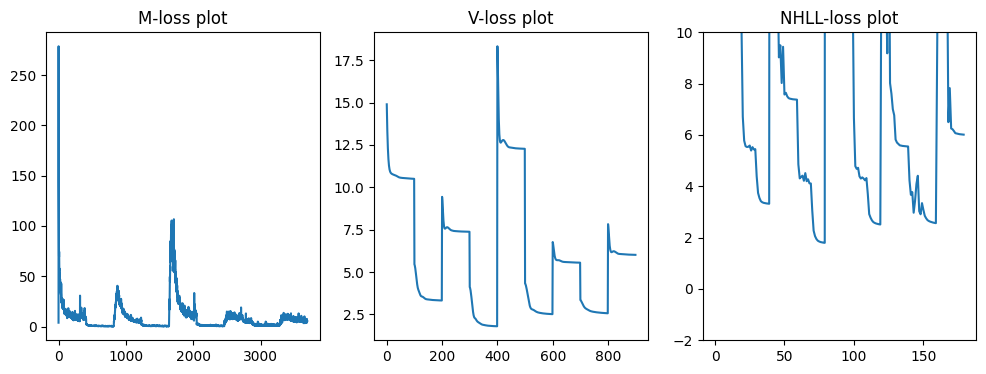

8-th main train train MAE, MSE, NHLL : 0.7734 deg, 0.4026, 6.0118
8-th main train test MAE, MSE, NHLL : 2.4015 deg, 5.6863, 52.8827
8-th main train test MAE, MSE: 3.4616 deg, 9.2798


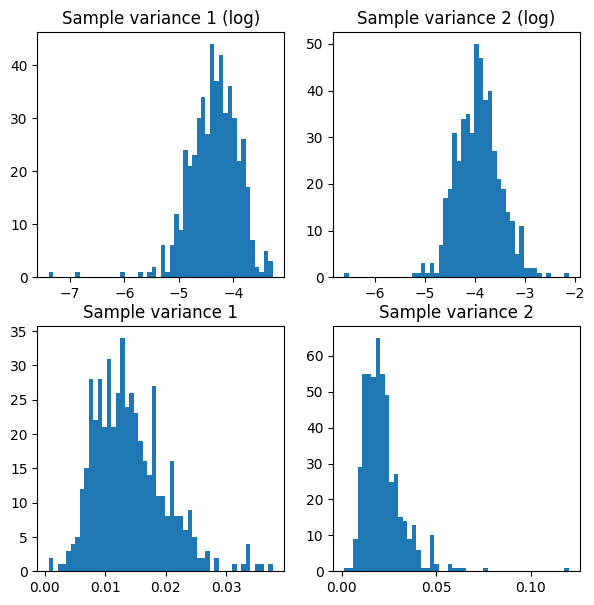

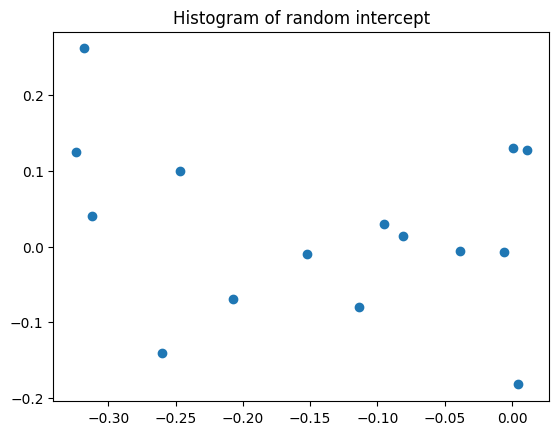

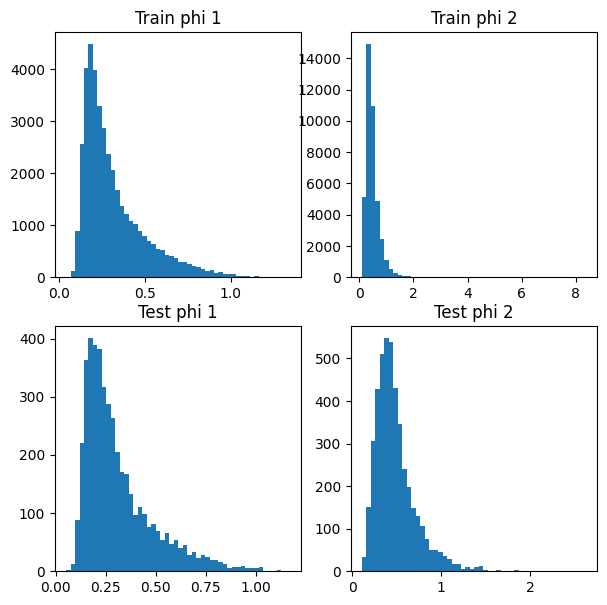

0-th epoch full h-lik loss (M-step) : 4.080407619476318
1-th epoch full h-lik loss (M-step) : 3.1274852752685547
2-th epoch full h-lik loss (M-step) : 3.4177849292755127
3-th epoch full h-lik loss (M-step) : 3.1407995223999023
4-th epoch full h-lik loss (M-step) : 2.8548388481140137
5-th epoch full h-lik loss (M-step) : 3.9872827529907227
6-th epoch full h-lik loss (M-step) : 3.045780658721924
7-th epoch full h-lik loss (M-step) : 3.2155532836914062
8-th epoch full h-lik loss (M-step) : 3.1555793285369873
9-th epoch full h-lik loss (M-step) : 3.3156914710998535
9-th V-step train loss : 2.849158763885498
19-th V-step train loss : 2.3843092918395996
29-th V-step train loss : 2.355741024017334
39-th V-step train loss : 2.295257568359375
49-th V-step train loss : 2.2731728553771973
59-th V-step train loss : 2.2619733810424805
69-th V-step train loss : 2.252882480621338
79-th V-step train loss : 2.246830463409424
89-th V-step train loss : 2.2417244911193848
99-th V-step train loss : 2.23729

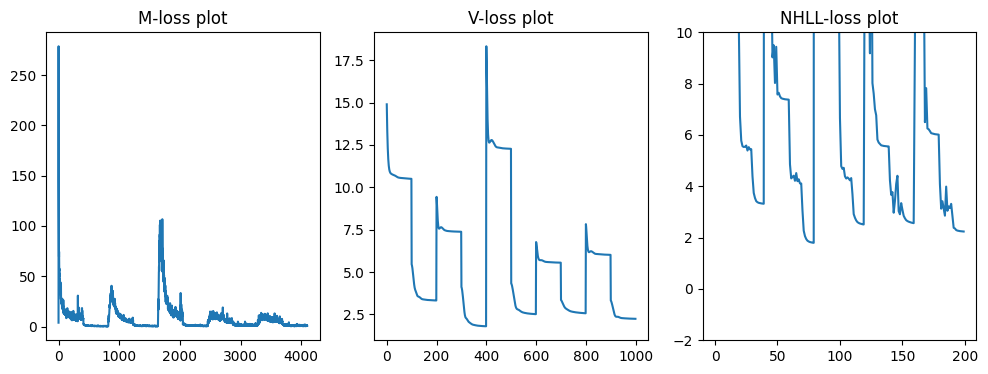

9-th main train train MAE, MSE, NHLL : 0.4320 deg, 0.1238, 2.2373
9-th main train test MAE, MSE, NHLL : 2.3111 deg, 5.4397, 108.6905
9-th main train test MAE, MSE: 3.3773 deg, 8.9098


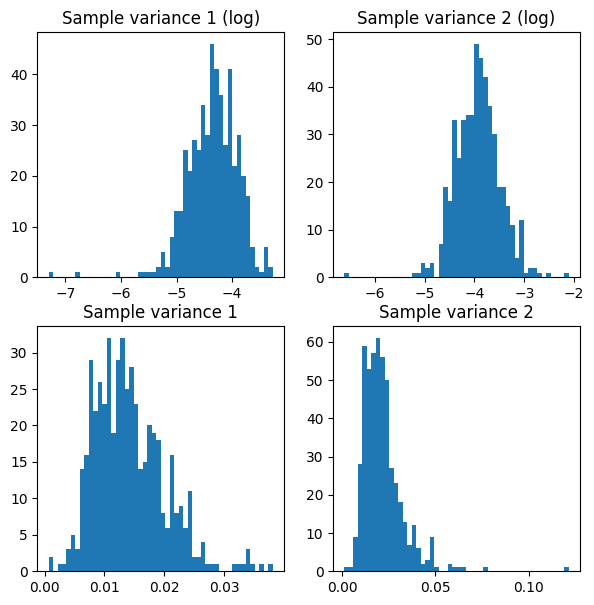

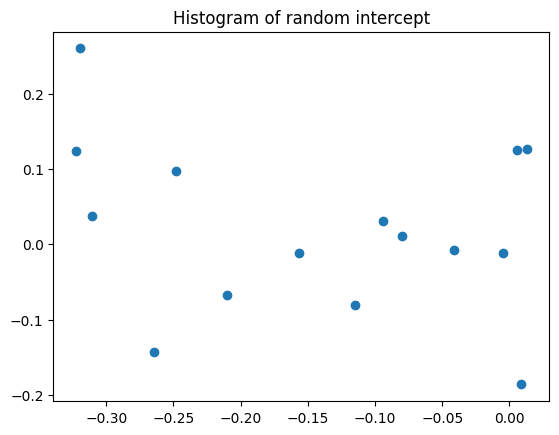

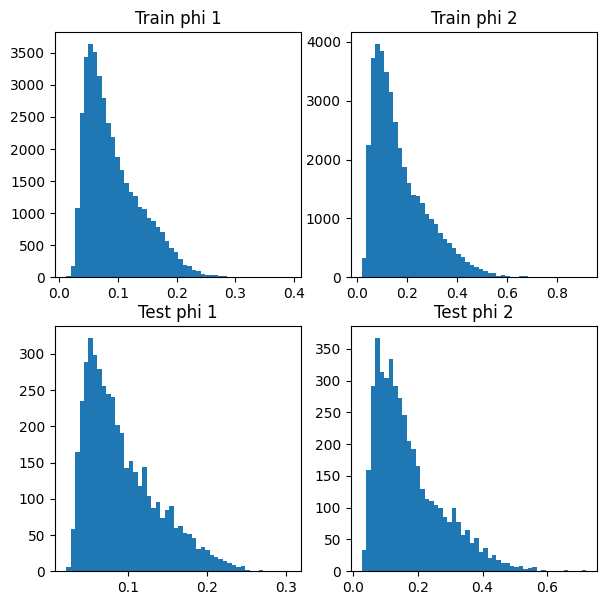

0-th epoch full h-lik loss (M-step) : 26.763408660888672
1-th epoch full h-lik loss (M-step) : 61.69401550292969
2-th epoch full h-lik loss (M-step) : 40.88330078125
3-th epoch full h-lik loss (M-step) : 34.257972717285156
4-th epoch full h-lik loss (M-step) : 26.710975646972656
5-th epoch full h-lik loss (M-step) : 20.890296936035156
6-th epoch full h-lik loss (M-step) : 21.808475494384766
7-th epoch full h-lik loss (M-step) : 12.646836280822754
8-th epoch full h-lik loss (M-step) : 8.68769359588623
9-th epoch full h-lik loss (M-step) : 6.435759544372559
9-th V-step train loss : 5.326382637023926
19-th V-step train loss : 5.233179092407227
29-th V-step train loss : 5.183951377868652
39-th V-step train loss : 5.126112461090088
49-th V-step train loss : 5.1087846755981445
59-th V-step train loss : 5.094842910766602
69-th V-step train loss : 5.085017681121826
79-th V-step train loss : 5.077937602996826
89-th V-step train loss : 5.0718865394592285
99-th V-step train loss : 5.0667886734008

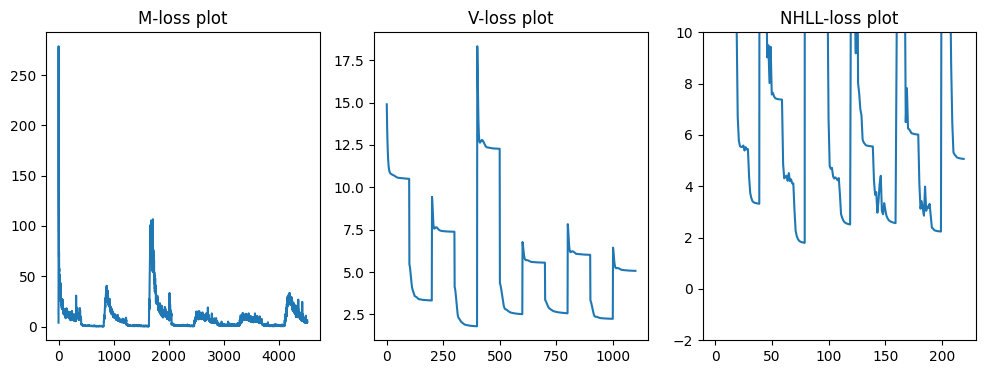

10-th main train train MAE, MSE, NHLL : 0.6238 deg, 0.2660, 5.0668
10-th main train test MAE, MSE, NHLL : 2.3437 deg, 5.5855, 64.5555
10-th main train test MAE, MSE: 3.3772 deg, 8.9916


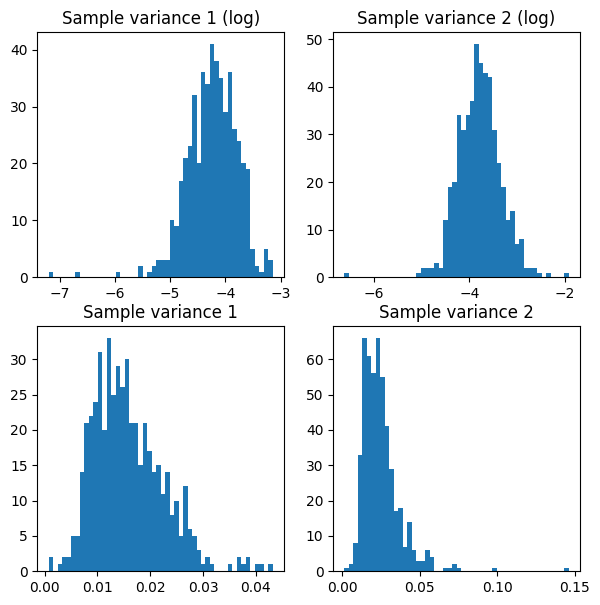

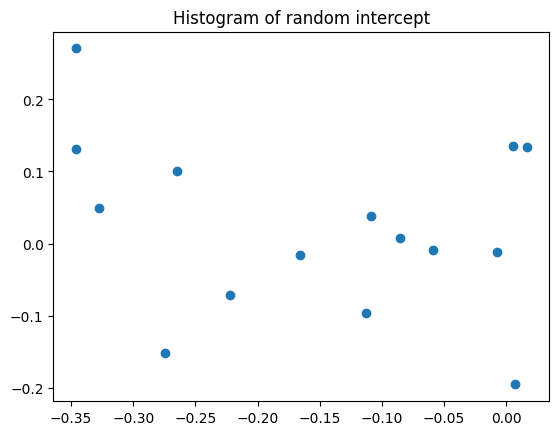

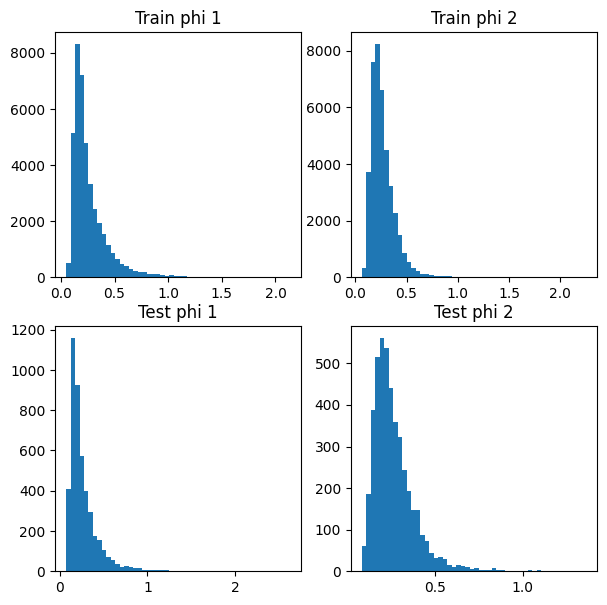

0-th epoch full h-lik loss (M-step) : 3.3921871185302734
1-th epoch full h-lik loss (M-step) : 3.505087375640869
2-th epoch full h-lik loss (M-step) : 2.89556884765625
3-th epoch full h-lik loss (M-step) : 2.928799867630005
4-th epoch full h-lik loss (M-step) : 2.654994010925293
5-th epoch full h-lik loss (M-step) : 2.6319985389709473
6-th epoch full h-lik loss (M-step) : 3.0158846378326416
7-th epoch full h-lik loss (M-step) : 3.6541054248809814
8-th epoch full h-lik loss (M-step) : 3.2365410327911377
9-th epoch full h-lik loss (M-step) : 2.363811492919922
9-th V-step train loss : 1.8350639343261719
19-th V-step train loss : 1.218132495880127
29-th V-step train loss : 1.0766944885253906
39-th V-step train loss : 1.0121066570281982
49-th V-step train loss : 0.9656593799591064
59-th V-step train loss : 0.9466124773025513
69-th V-step train loss : 0.9317383766174316
79-th V-step train loss : 0.9201161861419678
89-th V-step train loss : 0.9111051559448242
99-th V-step train loss : 0.90331

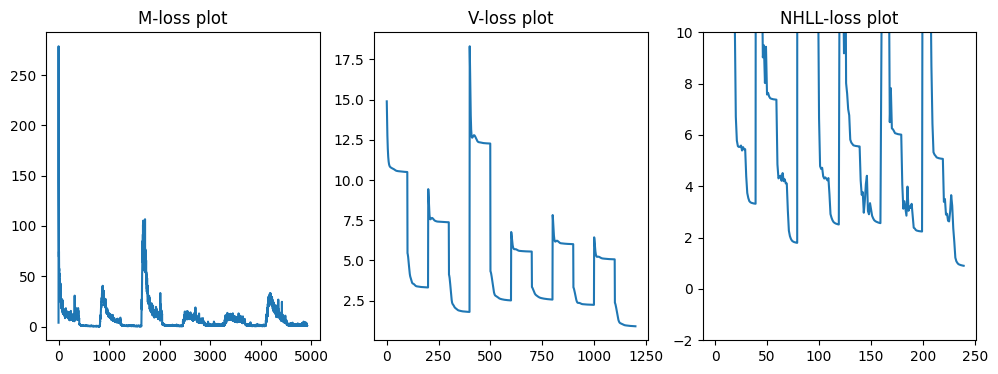

11-th main train train MAE, MSE, NHLL : 0.2992 deg, 0.0643, 0.9033
11-th main train test MAE, MSE, NHLL : 2.2832 deg, 5.3718, 193.6802
11-th main train test MAE, MSE: 3.3469 deg, 8.7913


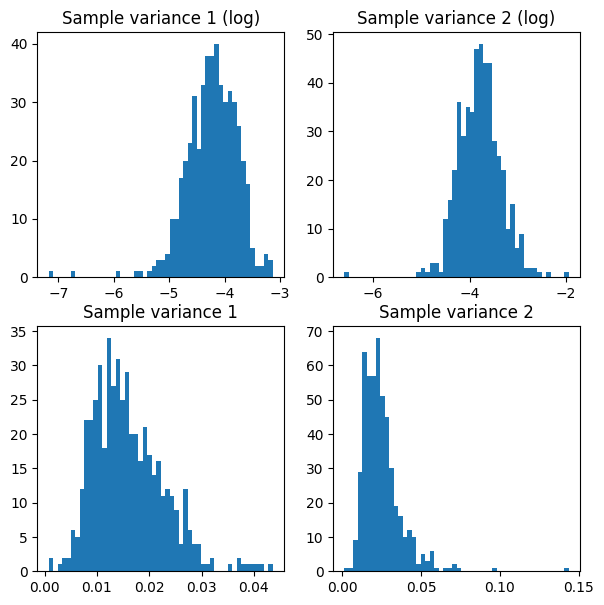

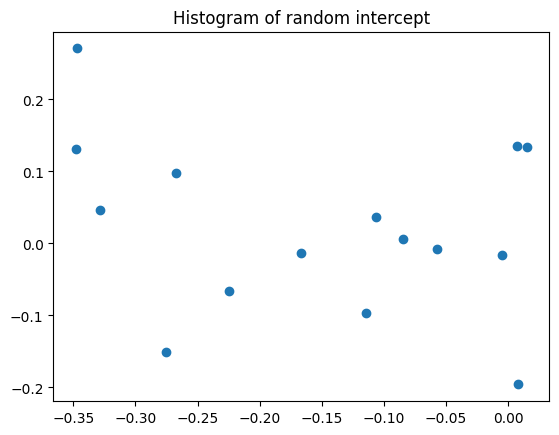

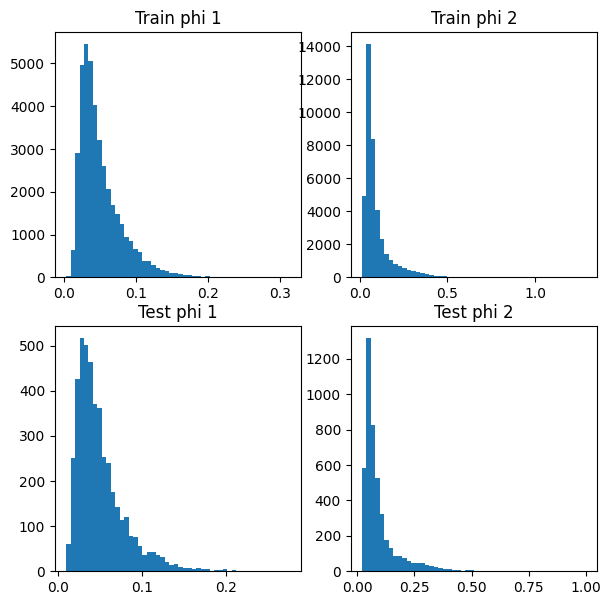

0-th epoch full h-lik loss (M-step) : 78.74351501464844
1-th epoch full h-lik loss (M-step) : 505.7813720703125
2-th epoch full h-lik loss (M-step) : 196.0408935546875
3-th epoch full h-lik loss (M-step) : 222949.140625
4-th epoch full h-lik loss (M-step) : 142.14724731445312
5-th epoch full h-lik loss (M-step) : 71.81103515625


In [ ]:
#@title test

for looid in [0,1,2] :

    train_ids = np.concatenate([ids[:looid], ids[(looid+1):]]).reshape(-1)
    train_images = torch.cat([images[:looid], images[(looid+1):]]).reshape(-1,36,60)
    train_hps = torch.cat([hps[:looid], hps[(looid+1):]]).reshape(-1,2)
    train_gazes = torch.cat([gazes[:fold], gazes[(looid+1):]]).reshape(-1,2)

    test_ids = ids[looid]
    test_images = images[looid]
    test_hps = hps[looid]
    test_gazes = gazes[looid]

    res_list.append(hetero_precision_without_val(
        train_ids, train_images, train_hps, train_gazes,
        test_ids, test_images, test_hps, test_gazes,
        ResNet_batchnorm.ResNet_batchnorm, hidden_features=hidden_features, K=2, initialize_Sigma=initialize_Sigma,
        mean_lr=mean_lr, variance_lr=variance_lr, weight_decay=weight_decay, batch_size=batch_size,
        pretrain_iter=pretrain_iter, m_pretrain_epoch=m_pretrain_epoch, v_pretrain_epoch=v_pretrain_epoch, max_iter=max_iter, mean_epoch=mean_epoch, v_step_iter=v_step_iter, patience=patience,
        device=device, experiment_name=f'{experiment_name}_{looid}', SEED=seed + looid,
        normalize=True, deg=True, test_unseen=False, weighted=True, variance_check=True, verbose=False, bins=50, reset_opt=reset_opt))


